In [1]:
import pandas as pd
import numpy as np
import GPy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
dataset = pd.read_csv('./merged.csv')

In [ ]:
dataset.head(2)

In [ ]:
num_features = ['hour', 'n_month', 'day_of_week', 'is_weekend_day', 'cur__precipIntensity', 'cur__precipProbability',
     'cur__temperature', 'cur__apparentTemperature', 'cur__humidity', 'cur__windSpeed', 'cur__windGust',
     'cur__cloudCover', 'cur__uvIndex', 'cur__visibility', 'daily__temperatureHigh']
X = dataset[num_features]
y = dataset['obs_count']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# choose subset of features to improve speed and accuracy
use_feats = 'hour,cur__precipIntensity,cur__apparentTemperature,cur__uvIndex,is_weekend_day'.split(',')

#subsampling

print("optimizing with subset of  data")
ind = np.random.permutation(np.arange(0,X_train.shape[0]))[0:500]
# scale data using standard scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[use_feats])
y_train_reshaped = np.expand_dims(y_train, axis=1)

# # create kernel (tried adding periodic kernel Matern52 and it did not improve the performance)
# kernel_radial = GPy.kern.RBF(X_train_scaled.shape[1], ARD=True)
# # create likelihood for the model and inference method
# poisson_likelihood = GPy.likelihoods.Poisson()
# laplace_inf = GPy.inference.latent_function_inference.Laplace()


# # run Gaussian process and optimize parameters
# m = GPy.core.GP(X=X_train_scaled[ind,:], Y=y_train_reshaped[ind,:], likelihood=poisson_likelihood,
#                 inference_method=laplace_inf, kernel=kernel_radial)
# m.optimize()  # more than 10 iterations does not improve the result any more based on my study

print("now optimizing with all data")
#
#kernel_radial = m.kern
# scale data using standard scaler
ind=np.arange(0,X_train.shape[0])
# create kernel (tried adding periodic kernel Matern52 and it did not improve the performance)
# kernel_radial = GPy.kern.RBF(X_train_scaled.shape[1], ARD=True)

# # create likelihood for the model and inference method
# poisson_likelihood = GPy.likelihoods.Poisson()
# laplace_inf = GPy.inference.latent_function_inference.Laplace()


# # run Gaussian process and optimize parameters
# m = GPy.core.GP(X=X_train_scaled[ind,:], Y=y_train_reshaped[ind,:], likelihood=poisson_likelihood,
#                 inference_method=laplace_inf, kernel=kernel_radial)
# m.optimize()  # more th

In [88]:
#check the estimated parameters
m.kern

rbf.,value,constraints,priors
variance,2.9468132078166542,+ve,
lengthscale,"(5,)",+ve,


In [89]:
# generate predictions from the scaled test data,
# GPy returns a tuple of 2 lists (means and variances)
X_test_scaled = scaler.transform(X_test[use_feats])
preds1 = m.predict(Xnew=X_test_scaled, include_likelihood=True)

 /home/benavoli/anaconda3/envs/mypy/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning:Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


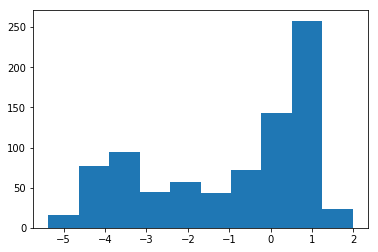

In [90]:
#I now predict directly the mean function (just for your understanding)
preds = m.predict_noiseless(Xnew=X_test_scaled,full_cov=True)
plt.hist(preds[0]); #this is the mean function of the GP
sampled_functions = np.random.multivariate_normal(preds[0][:,0],preds[1],500)#sampling from the posterior

In [91]:
sampled_functions.shape

(500, 828)

In [93]:
#the Poisson intensity is defined as exp(f), so
exp_sampled_functions=np.exp(sampled_functions)
mean_intensity=np.mean(exp_sampled_functions,axis=0).reshape(-1,1)# approximatively this is what is in preds1[0]
mean_intensity#this is the mean intensity function estimated by the GP

array([[2.28547738e+00],
       [1.24915408e-02],
       [2.65559545e-01],
       [3.55165389e+00],
       [3.58586444e+00],
       [2.38993825e-02],
       [1.82364371e+00],
       [4.57956093e-01],
       [1.81279996e-01],
       [7.41339111e-01],
       [1.74949930e+00],
       [4.96818995e-02],
       [1.72236623e-02],
       [1.36130803e+00],
       [1.18170535e-02],
       [3.20214211e+00],
       [1.96064443e+00],
       [2.88519025e+00],
       [7.36510948e-01],
       [1.20033448e+00],
       [2.05588322e+00],
       [1.51470943e+00],
       [2.17010519e+00],
       [2.82497027e-02],
       [2.36020478e+00],
       [1.07637840e+00],
       [8.66641154e-02],
       [3.01989321e+00],
       [2.62615056e+00],
       [2.08618774e-02],
       [2.51026609e-02],
       [3.82729797e-02],
       [2.28666630e+00],
       [4.56215170e-02],
       [1.96889302e+00],
       [4.65928029e+00],
       [6.70371441e-01],
       [5.43018378e-02],
       [7.96067687e-02],
       [1.71575463e+00],


the mean intensity gives you the mean rate of the posson distribution, as higher as larger is the numbe rof events for that relative row (X_test)

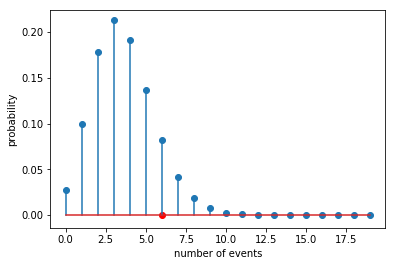

In [123]:
import scipy as sp
xx= np.arange(0,20)
i=4#let's fix one test point
plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i],0,color='r')#true event

In [124]:
#your point estimator of the counts should be mean intensity 
estimator = mean_intensity[i] #this the average of the above distribution
print(np.sum(xx*sp.stats.poisson(mean_intensity[i]).pmf(xx)),estimator)#note that they are equal

3.585864403706715 [3.58586444]


In [125]:
#you can then compute the MSE as
np.mean((mean_intensity[:,0]-y_test.values)**2)

2.3552399515031084

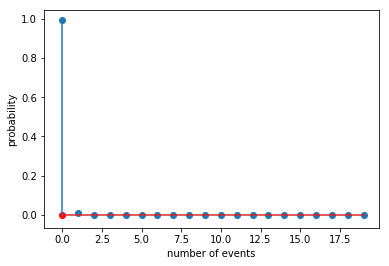

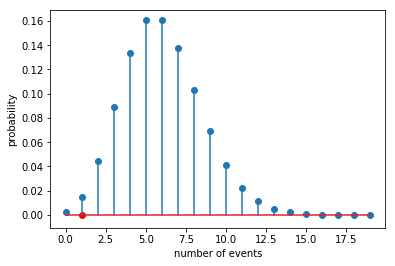

In [127]:
ind=np.argsort(np.std(exp_sampled_functions,axis=0))#sort instances with higher variance

#this is an instance with low uncertainty, can you explain it from the values of Xtest?
i=ind[0]#is it night?
plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i],0,color='r')#true event

plt.figure()
#this is an instance with high uncertainty, can you explain it from the values of Xtest?
i=ind[-2]
plt.stem(xx,sp.stats.poisson(mean_intensity[i]).pmf(xx))
plt.ylabel('probability')
plt.xlabel('number of events')
plt.scatter(y_test.values[i],0,color='r')#true event

In [ ]:
#maybe you can also test a periodic kernel (just to check if MSE decreases)
kernel1 = GPy.kern.PeriodicExponential(X_train_scaled.shape[1], ARD=True)
#or a combination of RBF and Periodic
kernel1 = GPy.kern.RBF(X_train_scaled.shape[1], ARD=True)+GPy.kern.PeriodicExponential(X_train_scaled.shape[1], ARD=True)